In [1]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scikit-learn

In [ ]:
pip install matplotlib

In [36]:
import pandas as pd

# Load the updated data file
file_path = 'all_data.csv'  # Make sure the file is in .xlsx format
data = pd.read_csv(file_path)


# Display the first few rows of the dataset to understand the new features
data.head()




,frame.time,ip.src,ip.dst,_ws.col.Protocol,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport,frame.len
0,"Mar 27, 2018 20:00:00.004970000 Eastern Daylig...",35.226.150.89,192.168.0.10,TCP,443.0,48281.0,NaN,NaN,66
1,"Mar 27, 2018 20:00:00.004974000 Eastern Daylig...",35.226.150.89,192.168.0.10,TCP,443.0,48281.0,NaN,NaN,70
2,"Mar 27, 2018 20:00:00.012820000 Eastern Daylig...",35.226.84.129,192.168.0.53,TCP,443.0,40675.0,NaN,NaN,66
3,"Mar 27, 2018 20:00:00.012823000 Eastern Daylig...",35.226.84.129,192.168.0.53,TCP,443.0,40675.0,NaN,NaN,70
4,"Mar 27, 2018 20:00:00.012825000 Eastern Daylig...",NaN,NaN,ARP,NaN,NaN,NaN,NaN,60


In [37]:
# Strip any leading/trailing spaces in column names
data.columns = data.columns.str.strip()

# Check if 'frame.len' exists after cleaning column names
print('frame.len' in data.columns)
print('tcp.srcport' in data.columns)
print(data.head())

True
True
                                          frame.time         ip.src  \
0  Mar 27, 2018 20:00:00.004970000 Eastern Daylig...  35.226.150.89   
1  Mar 27, 2018 20:00:00.004974000 Eastern Daylig...  35.226.150.89   
2  Mar 27, 2018 20:00:00.012820000 Eastern Daylig...  35.226.84.129   
3  Mar 27, 2018 20:00:00.012823000 Eastern Daylig...  35.226.84.129   
4  Mar 27, 2018 20:00:00.012825000 Eastern Daylig...            NaN   

         ip.dst _ws.col.Protocol  tcp.srcport  tcp.dstport  udp.srcport  \
0  192.168.0.10              TCP        443.0      48281.0          NaN   
1  192.168.0.10              TCP        443.0      48281.0          NaN   
2  192.168.0.53              TCP        443.0      40675.0          NaN   
3  192.168.0.53              TCP        443.0      40675.0          NaN   
4           NaN              ARP          NaN          NaN          NaN   

   udp.dstport  frame.len  
0          NaN         66  
1          NaN         70  
2          NaN         66  


In [38]:
# Remove time zone information from frame.time
data['frame.time'] = data['frame.time'].str.replace(r'(\d{2}:\d{2}:\d{2}\.\d+).*', r'\1', regex=True)

# Convert frame.time to datetime
data['frame.time'] = pd.to_datetime(data['frame.time'], errors='coerce')

# Drop rows with missing timestamps (optional)
data.dropna(subset=['frame.time'], inplace=True)

# Sort by time to ensure accurate timing calculations
data.sort_values(by='frame.time', inplace=True)

print(data['frame.time'])


0         2018-03-27 20:00:00.004970
1         2018-03-27 20:00:00.004974
2         2018-03-27 20:00:00.012820
3         2018-03-27 20:00:00.012823
4         2018-03-27 20:00:00.012825
                     ...            
1048570   2018-03-27 20:35:37.299970
1048571   2018-03-27 20:35:37.302790
1048572   2018-03-27 20:35:37.302793
1048573   2018-03-27 20:35:37.315539
1048574   2018-03-27 20:35:37.315543
Name: frame.time, Length: 1048575, dtype: datetime64[ns]


In [39]:
# Merge tcp.srcport and udp.srcport into a single srcport column
data['srcport'] = data['tcp.srcport'].fillna(data['udp.srcport'])
data['dstport'] = data['tcp.dstport'].fillna(data['udp.dstport'])

# Add protocol_type column to indicate whether it’s TCP or UDP
data['protocol_type'] = data.apply(
    lambda row: 'TCP' if pd.notnull(row['tcp.srcport']) else ('UDP' if pd.notnull(row['udp.srcport']) else None),
    axis=1
)

# Drop the original tcp and udp port columns to clean up the dataset
data.drop(columns=['tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport'], inplace=True)

data.head()
# Define flow identifier as a combination of src/dst IP and src/dst port
data['flow_id'] = (data['ip.src'].astype(str) + ':' +
                   data['srcport'].astype(str) + '-' +
                   data['ip.dst'].astype(str) + ':' +
                   data['dstport'].astype(str))

# Calculate inter-packet time within each flow
data['time_diff'] = data.groupby('flow_id')['frame.time'].diff().dt.total_seconds()

# Aggregate statistics for each flow
flow_data = data.groupby('flow_id').agg(
    packet_count=('frame.len', 'size'),          # Number of packets in the flow
    total_bytes=('frame.len', 'sum'),            # Total bytes in the flow
    avg_packet_size=('frame.len', 'mean'),       # Average packet size in the flow
    avg_packet_rate=('time_diff', lambda x: x.count() / x.sum() if x.sum() > 0 else 0), # Packets per second
    avg_inter_packet_time=('time_diff', 'mean')  # Average time between packets
).reset_index()

# Keep the first occurrence of each flow_id's original fields (e.g., ip.src, ip.dst)
flow_metadata = data.groupby('flow_id').first().reset_index()[['flow_id', 'ip.src', 'ip.dst', '_ws.col.Protocol', 'protocol_type', 'srcport', 'dstport']]

# Merge flow-level aggregates with metadata
flow_data = flow_data.merge(flow_metadata, on='flow_id', how='left')

# Directionality Analysis: incoming and outgoing packet/byte counts per flow
# Define direction as either 'incoming' or 'outgoing' based on the source IP
data['direction'] = data['ip.src'].apply(lambda x: 'outgoing' if str(x).startswith("192.168") else 'incoming')

# Separate counts for incoming and outgoing packets and bytes
directional_stats = data.groupby(['flow_id', 'direction']).agg(
    packet_count=('frame.len', 'size'),
    total_bytes=('frame.len', 'sum')
).reset_index()

# Pivot the table to create separate columns for incoming and outgoing stats
directional_stats = directional_stats.pivot(index='flow_id', columns='direction', values=['packet_count', 'total_bytes']).fillna(0)

# Flatten MultiIndex columns created by pivot
directional_stats.columns = ['_'.join(col).strip() for col in directional_stats.columns.values]
directional_stats = directional_stats.reset_index()

# Rename columns for consistency
directional_stats = directional_stats.rename(columns={
    'packet_count_incoming': 'direction_packet_count_incoming',
    'packet_count_outgoing': 'direction_packet_count_outgoing',
    'total_bytes_incoming': 'direction_total_bytes_incoming',
    'total_bytes_outgoing': 'direction_total_bytes_outgoing'
})

# Merge direction stats back into flow_data
flow_data = flow_data.merge(directional_stats, on='flow_id', how='left')


# Save the processed data to a new CSV
flow_data.to_csv('fingerprint_features_with_metadata.csv', index=False)

# Save the processed data to a new CSV
#flow_data.to_csv('fingerprint_features_with_metadata.csv', index=False)



In [40]:
# Print the column names to ensure 'frame.len' is correct
data = pd.read_csv('fingerprint_features_with_metadata.csv')
print(data.columns)
data.head()


Index(['flow_id', 'packet_count', 'total_bytes', 'avg_packet_size',
       'avg_packet_rate', 'avg_inter_packet_time', 'ip.src', 'ip.dst',
       '_ws.col.Protocol', 'protocol_type', 'srcport', 'dstport',
       'direction_packet_count_incoming', 'direction_packet_count_outgoing',
       'direction_total_bytes_incoming', 'direction_total_bytes_outgoing'],
      dtype='object')


,flow_id,packet_count,total_bytes,avg_packet_size,avg_packet_rate,avg_inter_packet_time,ip.src,ip.dst,_ws.col.Protocol,protocol_type,srcport,dstport,direction_packet_count_incoming,direction_packet_count_outgoing,direction_total_bytes_incoming,direction_total_bytes_outgoing
0,0.0.0.0:68.0-255.255.255.255:67.0,318,135892,427.333333,0.150308,6.652986,0.0.0.0,255.255.255.255,DHCP,UDP,68.0,67.0,318.0,0.0,135892.0,0.0
1,104.199.241.246:4070.0-192.168.0.15:47321.0,60,4740,79.000000,0.028919,34.579505,104.199.241.246,192.168.0.15,TCP,TCP,4070.0,47321.0,60.0,0.0,4740.0,0.0
2,104.208.28.54:443.0-192.168.0.45:42171.0,522,229662,439.965517,0.248185,4.029259,104.208.28.54,192.168.0.45,TLSv1.2,TCP,443.0,42171.0,522.0,0.0,229662.0,0.0
3,108.61.73.244:123.0-192.168.0.15:48705.0,14,1288,92.000000,0.006861,145.755493,108.61.73.244,192.168.0.15,NTP,UDP,123.0,48705.0,14.0,0.0,1288.0,0.0
4,129.250.35.250:123.0-192.168.0.41:46248.0,6,552,92.000000,0.002418,413.565454,129.250.35.250,192.168.0.41,NTP,UDP,123.0,46248.0,6.0,0.0,552.0,0.0


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


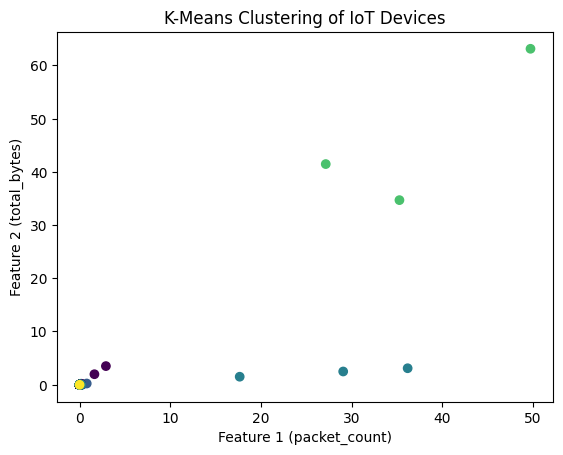

   packet_count  total_bytes  avg_packet_size  avg_packet_rate  \
0      0.042494     0.018860         1.609512        -0.668516   
1     -0.021135    -0.021906        -0.654036        -0.668516   
2      0.092805     0.048006         1.691598        -0.668515   
3     -0.032479    -0.022979        -0.569559        -0.668516   
4     -0.034452    -0.023208        -0.569559        -0.668516   

   avg_inter_packet_time    ip.src    ip.dst   srcport   dstport  Cluster  
0               0.143186 -3.448891  1.438845 -1.219756 -1.116336        3  
1               1.234558 -1.375033  0.265893 -1.041969  1.118400        3  
2               0.040650 -1.374402  0.265893 -1.203097  0.874846        3  
3               5.579328 -1.306584  0.265893 -1.217312  1.183852        3  
4              16.045373 -0.876345  0.265893 -1.217312  1.067656        7  


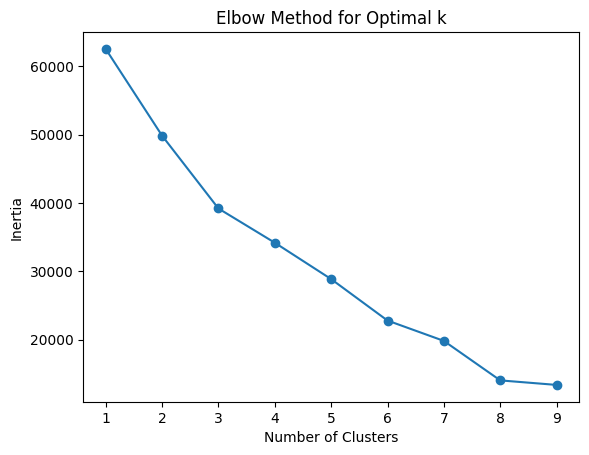

In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import ipaddress


# Load your updated data
data = pd.read_csv('fingerprint_features_with_metadata.csv')


# Step 1: Select relevant features for clustering
features = ['packet_count', 'total_bytes', 'avg_packet_size', 'avg_packet_rate', 'avg_inter_packet_time', 'ip.src',	'ip.dst', 'srcport', 'dstport']

X = data[features].copy() 
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return float('nan')  # For any invalid IPs

# Apply the conversion function to IP addresses
X.loc[:, 'ip.src'] = X['ip.src'].apply(ip_to_int)
X.loc[:, 'ip.dst'] = X['ip.dst'].apply(ip_to_int)

X.dropna(inplace=True)
# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame (optional, for reference)
scaled_df = pd.DataFrame(X_scaled, columns=features)

# Step 3: Apply K-Means clustering
kmeans = KMeans(n_clusters=8, random_state=42)  # Adjust n_clusters as needed
kmeans.fit(X_scaled)

# Get cluster labels
labels = kmeans.labels_

# Add cluster labels to the scaled DataFrame for reference
scaled_df['Cluster'] = labels

# Step 4: Visualize the clustering results (scatter plot of first two features)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
plt.xlabel('Feature 1 (packet_count)')
plt.ylabel('Feature 2 (total_bytes)')
plt.title('K-Means Clustering of IoT Devices')
plt.show()

# Step 5 (Optional): Display the first few rows of the scaled data with cluster labels
print(scaled_df.head())

# Step 6 (Optional): Elbow method to find the optimal number of clusters
inertia = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [11]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install tf_keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:

!pip install transformers[torch]
!pip install accelerate
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [49]:
import accelerate
print(accelerate.__version__)

1.1.1


In [16]:
!pip install transformers[torch] accelerate --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [17]:
pip install setuptools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [50]:
import pandas as pd
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load your updated data
data = pd.read_csv('fingerprint_features_with_metadata.csv')

# Select relevant features and prepare sequences for GPT-2
features = ['packet_count', 'total_bytes', 'avg_packet_size', 'avg_packet_rate', 'avg_inter_packet_time']
sequences = data[features].astype(str).values
input_sequences = [' '.join(seq) for seq in sequences]

train_sequences, test_sequences = train_test_split(input_sequences, test_size=0.2, random_state=42)

# Step 1: Initialize GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set eos_token as padding token

# Step 2: Tokenize the data
train_tokenized_data = tokenizer(
    train_sequences,
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=128  # Adjust max_length based on the expected sequence length
)

test_tokenized_data = tokenizer(
    test_sequences,
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=128  # Adjust max_length based on the expected sequence length
)

# Step 3: Load GPT-2 model for fine-tuning
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Step 4: Prepare dataset for PyTorch
class IoTDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data['input_ids']
        self.attention_mask = tokenized_data['attention_mask']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.input_ids[idx]  # Labels are the same as input for language modeling
        }

train_dataset = IoTDataset(train_tokenized_data)
test_dataset = IoTDataset(test_tokenized_data)

# Step 5: Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',           # Output directory
    overwrite_output_dir=True,
    num_train_epochs=3,               # Number of epochs (adjust as needed)
    per_device_train_batch_size=4,    # Batch size per device
    per_device_eval_batch_size=4,     # Batch size for evaluation
    warmup_steps=10,                  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # Strength of weight decay
    logging_dir='./logs',             # Directory for storing logs
    logging_steps=1000,
    save_steps=999999,                    # Save model every 50 steps
    evaluation_strategy="epoch",
)

# Step 6: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Step 7: Train the model
trainer.train()

# Step 8 (Optional): Save the model and tokenizer
model.save_pretrained('./fine_tuned_gpt2')
tokenizer.save_pretrained('./fine_tuned_gpt2')




C:\Users\dmaurya\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 23%|██▎       | 1000/4287 [12:39<42:22,  1.29it/s]

{'loss': 1.7257, 'grad_norm': 5.630321979522705, 'learning_rate': 3.8426467149871406e-05, 'epoch': 0.7}


                                                   
 33%|███▎      | 1429/4287 [18:41<33:39,  1.42it/s]

{'eval_loss': 1.3228543996810913, 'eval_runtime': 39.2889, 'eval_samples_per_second': 36.372, 'eval_steps_per_second': 9.112, 'epoch': 1.0}


 47%|████▋     | 2000/4287 [25:58<26:29,  1.44it/s]  

{'loss': 1.3454, 'grad_norm': 4.002628326416016, 'learning_rate': 2.673602992751929e-05, 'epoch': 1.4}


                                                   
 67%|██████▋   | 2858/4287 [37:27<18:06,  1.32it/s]

{'eval_loss': 1.2348395586013794, 'eval_runtime': 38.4912, 'eval_samples_per_second': 37.125, 'eval_steps_per_second': 9.301, 'epoch': 2.0}


 70%|██████▉   | 3000/4287 [39:15<17:06,  1.25it/s]  

{'loss': 1.2593, 'grad_norm': 5.29734992980957, 'learning_rate': 1.5045592705167175e-05, 'epoch': 2.1}


 93%|█████████▎| 4000/4287 [51:49<03:51,  1.24it/s]

{'loss': 1.1925, 'grad_norm': 5.175716400146484, 'learning_rate': 3.3551554828150576e-06, 'epoch': 2.8}


                                                   
100%|██████████| 4287/4287 [56:21<00:00,  1.27it/s]


{'eval_loss': 1.1997976303100586, 'eval_runtime': 39.12, 'eval_samples_per_second': 36.529, 'eval_steps_per_second': 9.151, 'epoch': 3.0}
{'train_runtime': 3381.3252, 'train_samples_per_second': 5.07, 'train_steps_per_second': 1.268, 'train_loss': 1.3684486227211263, 'epoch': 3.0}


('./fine_tuned_gpt2\\tokenizer_config.json',
 './fine_tuned_gpt2\\special_tokens_map.json',
 './fine_tuned_gpt2\\vocab.json',
 './fine_tuned_gpt2\\merges.txt',
 './fine_tuned_gpt2\\added_tokens.json')

In [51]:
# Display tokenized data for verification (optional)
print(train_tokenized_data['input_ids'][:3])

tensor([[   18, 36141, 28174,    13, 24840, 24840, 24840,  2682,   718, 19060,
            21,    13, 41977,  2791,   352,    13,    20,    68,    12,  3312,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256],
        [ 1065,   860,  5705,  9415,    13,    15, 17031,    13,    22,  2598,
          1983,  3104,  1983, 42830,    19,   657,    13,   405, 28362, 16817,
          1507,  1507,  1507,  1507, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256],
        [   17, 27795, 13374,    13,    15,  5323,   830,    13,    15,   362,
            68,    12,  3312, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256]])


In [52]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the fine-tuned model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('./fine_tuned_gpt2')
model = GPT2LMHeadModel.from_pretrained('./fine_tuned_gpt2')
model.eval()  # Set model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Select a sample input text (base sequence) to generate new sequences
input_text = test_sequences[0]  # Example: use the first sequence as the input
input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to(device)

# Generate a new sequence based on the trained model
generated_sequence = model.generate(
    input_ids,
    max_length=128,             # Set the maximum length of the generated sequence
    num_return_sequences=1,     # Generate one sequence for now; adjust as needed
    no_repeat_ngram_size=2,     # Optional: prevent repetition
    do_sample=True,             # Enable sampling for variability
    top_k=50,                   # Use top-k sampling for diversity
    top_p=0.95,                 # Use nucleus sampling
    temperature=0.7             # Control the randomness of generation
)

# Decode and print the generated sequence
generated_text = tokenizer.decode(generated_sequence[0], skip_special_tokens=True)
print("Generated Sequence:")
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated Sequence:
58 4174 71.96551724137932 7251.908396946565 0.0001378947368421


In [53]:
# Generate sequences for a subset of input data and compare with real sequences
num_samples = 5  # Adjust the number of samples as needed
generated_sequences = []

for seq in test_sequences[:num_samples]:
    input_ids = tokenizer(seq, return_tensors='pt').input_ids.to(device)
    generated = model.generate(
        input_ids,
        max_length=128,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )
    generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    generated_sequences.append(generated_text)

# Display real and generated sequences for comparison
for real, generated in zip(test_sequences[:num_samples], generated_sequences):
    print(f"Real Sequence: {real}")
    print(f"Generated Sequence: {generated}")
    print('---')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Real Sequence: 58 4174 71.96551724137932 7251.908396946565 0.0001378947368421
Generated Sequence: 58 4174 71.96551724137932 7251.908396946565 0.0001378947368421
---
Real Sequence: 3 514 171.33333333333334 400000.00000000006 2.5e-06
Generated Sequence: 3 514 171.33333333333334 400000.00000000006 2.5e-06
---
Real Sequence: 4 396 99.0 24390.243902439022 4.1e-05
Generated Sequence: 4 396 99.0 24390.243902439022 4.1e-05
---
Real Sequence: 56 7276 129.92857142857142 7577.845136401213 0.0001319636363636
Generated Sequence: 56 7276 129.92857142857142 7577.845136401213 0.0001319636363636
---
Real Sequence: 2 194 97.0 333333.3333333333 3e-06
Generated Sequence: 2 194 97.0 333333.3333333333 3e-06
---


In [57]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

# Function to get embedding from text
def get_embedding(text):
    input_ids = tokenizer(text, return_tensors='pt').input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    return outputs.logits.mean(dim=1).cpu().numpy().flatten()  # Average logits as sequence embedding

# Calculate cosine similarity between real and generated sequences
similarities = []
for real, generated in zip(test_sequences[:num_samples], generated_sequences):
    real_embedding = get_embedding(real)
    generated_embedding = get_embedding(generated)
    similarity = cosine_similarity([real_embedding], [generated_embedding])[0][0]
    similarities.append(similarity)
    print(f"Cosine Similarity between Real and Generated: {similarity}")

# Print the average similarity score
average_similarity = np.mean(similarities)
print(f"Average Cosine Similarity: {average_similarity}")

Cosine Similarity between Real and Generated: 0.9999998807907104
Cosine Similarity between Real and Generated: 0.9999996423721313
Cosine Similarity between Real and Generated: 1.0000001192092896
Cosine Similarity between Real and Generated: 1.0000001192092896
Cosine Similarity between Real and Generated: 0.9999999403953552
Average Cosine Similarity: 0.9999998807907104


In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming `real_embeddings` and `generated_embeddings` are lists of embeddings
real_embeddings = np.array([get_embedding(seq) for seq in test_sequences[:num_samples]])
generated_embeddings = np.array([get_embedding(seq) for seq in generated_sequences])

# Cluster real embeddings to create "labels"
n_clusters = 5  # Number of device behavior types
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(real_embeddings)
real_labels = kmeans.predict(real_embeddings)
generated_labels = kmeans.predict(generated_embeddings)

# Check if each generated sequence is in the same cluster as its real counterpart
correct_predictions = np.sum(real_labels == generated_labels)
accuracy = correct_predictions / len(generated_embeddings)
print("Cluster-based Accuracy:", accuracy)


Cluster-based Accuracy: 1.0
